In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
from numpy import linalg as la
from scipy.sparse import issparse
import loompy
import anndata
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.8.12) on 2024-07-02 10:44.


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80,dpi_save=300, facecolor='white')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5


In [3]:
import os
os.chdir('D:/KP/EKP_RKP')

In [4]:
import scanpy.external as sce

In [62]:
adata = sc.read('EKP_RKP_immune_pp_and_concatenated_04-22-24.h5ad')
adata

AnnData object with n_obs × n_vars = 5140 × 16482
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'tissue', 'type', 'leiden', 'batch'
    var: 'gene_ids_2', 'feature_types_2', 'mt_2', 'n_cells_2-0', 'n_cells_by_counts_2-0', 'mean_counts_2-0', 'pct_dropout_by_counts_2-0', 'total_counts_2-0', 'n_cells_2-1', 'n_cells_by_counts_2-1', 'mean_counts_2-1', 'pct_dropout_by_counts_2-1', 'total_counts_2-1'
    obsm: 'X_pca', 'X_umap'

In [63]:
adata.obs['tissue_1'] = 'Immune'

In [64]:
adata.obs

n_genes  n_genes_by_counts  total_counts  \
AAACCCACAACACACT-1-0     1224               1224        5703.0   
AAACCCACAGACTCTA-1-0     1280               1279        4325.0   
AAACGAACACAACGTT-1-0     1853               1852        6411.0   
AAACGAACAGACGATG-1-0     1839               1839        4647.0   
AAACGAAGTTTGGGTT-1-0     1438               1438        3224.0   
...                       ...                ...           ...   
TTTGACTAGATCGGTG-1-1     2571               2569        8336.0   
TTTGACTGTTGTGGAG-1-1     1243               1243        5308.0   
TTTGATCGTGCGTGCT-1-1     1629               1628        4435.0   
TTTGGAGTCTATCCAT-1-1     2961               2960       10369.0   
TTTGTTGGTGAGTTTC-1-1     1946               1946        5477.0   

                      total_counts_mt  pct_counts_mt     tissue type leiden  \
AAACCCACAACACACT-1-0              7.0       0.122742  allograft  EKP      0   
AAACCCACAGACTCTA-1-0             36.0       0.832370  allograft  EKP      1   
AAACGAACACAACGTT-1-0            125.0       1.949774  allograft  EKP      0   
AAACGAACAGACGATG-1-0              1.0       0.021519  allograft  EKP      4   
AAACGAAGTTTGGGTT-1-0             27.0       0.837469  allograft  EKP      3   
...                               ...            ...        ...  ...    ...   
TTTGACTAGATCGGTG-1-1            176.0       2.111324  allograft  RKP      2   
TTTGACTGTTGTGGAG-1-1            152.0       2.863602  allograft  RKP      3   
TTTGATCGTGCGTGCT-1-1             31.0       0.698985  allograft  RKP      2   
TTTGGAGTCTATCCAT-1-1             86.0       0.829395  allograft  RKP      2   
TTTGTTGGTGAGTTTC-1-1            160.0       2.921307  allograft  RKP      5   

                     batch tissue_1  
AAACCCACAACACACT-1-0     0   Immune  
AAACCCACAGACTCTA-1-0     0   Immune  
AAACGAACACAACGTT-1-0     0   Immune  
AAACGAACAGACGATG-1-0     0   Immune  
AAACGAAGTTTGGGTT-1-0     0   Immune  
...                    ...      ...  
TTTGACTAGATCGGTG-1-1     1   Immune  
TTTGACTGTTGTGGAG-1-1     1   Immune  
TTTGATCGTGCGTGCT-1-1     1   Immune  
TTTGGAGTCTATCCAT-1-1     1   Immune  
TTTGTTGGTGAGTTTC-1-1     1   Immune  

[5140 rows x 10 columns]

In [65]:
adata.obs.type = adata.obs.type.astype('category')
adata.obs.tissue_1 = adata.obs.tissue_1.astype('category')

In [66]:
df = pd.crosstab(adata.obs['type'], adata.obs['tissue_1'])
df

tissue_1  Immune
type            
EKP         3481
RKP         1659

In [67]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [68]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^Hb[^(P)]"))

adata.var

gene_ids_2  feature_types_2   mt_2  n_cells_2-0  \
Mrpl15          ENSMUSG00000033845  Gene Expression  False          489   
Lypla1          ENSMUSG00000025903  Gene Expression  False          753   
Tcea1           ENSMUSG00000033813  Gene Expression  False         1096   
Atp6v1h         ENSMUSG00000033793  Gene Expression  False         1521   
Rb1cc1          ENSMUSG00000025907  Gene Expression  False         1977   
...                            ...              ...    ...          ...   
Csprs           ENSMUSG00000062783  Gene Expression  False           17   
Vamp7           ENSMUSG00000051412  Gene Expression  False          280   
Tmlhe           ENSMUSG00000079834  Gene Expression  False           45   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression  False           48   
AC149090.1      ENSMUSG00000095041  Gene Expression  False          582   

                n_cells_by_counts_2-0  mean_counts_2-0  \
Mrpl15                            489         0.174057   
Lypla1                            753         0.292388   
Tcea1                            1096         0.582167   
Atp6v1h                          1521         0.959450   
Rb1cc1                           1977         1.086080   
...                               ...              ...   
Csprs                              17         0.004031   
Vamp7                             280         0.100071   
Tmlhe                              45         0.020631   
CAAA01147332.1                     48         0.012568   
AC149090.1                        582         0.291439   

                pct_dropout_by_counts_2-0  total_counts_2-0  n_cells_2-1  \
Mrpl15                          88.404079             734.0          503   
Lypla1                          82.143704            1233.0          576   
Tcea1                           74.009960            2455.0          996   
Atp6v1h                         63.931705            4046.0          740   
Rb1cc1                          53.118331            4580.0          917   
...                                   ...               ...          ...   
Csprs                           99.596870              17.0           33   
Vamp7                           93.360209             422.0          315   
Tmlhe                           98.932891              87.0           96   
CAAA01147332.1                  98.861750              53.0           69   
AC149090.1                      86.198719            1229.0          684   

                n_cells_by_counts_2-1  mean_counts_2-1  \
Mrpl15                            503         0.265946   
Lypla1                            576         0.294414   
Tcea1                             996         0.744865   
Atp6v1h                           740         0.513153   
Rb1cc1                            917         0.676036   
...                               ...              ...   
Csprs                              33         0.012973   
Vamp7                             315         0.154234   
Tmlhe                              96         0.056937   
CAAA01147332.1                     69         0.025946   
AC149090.1                        684         0.642162   

                pct_dropout_by_counts_2-1  total_counts_2-1     mt   ribo  \
Mrpl15                          81.873874             738.0  False  False   
Lypla1                          79.243243             817.0  False  False   
Tcea1                           64.108108            2067.0  False  False   
Atp6v1h                         73.333333            1424.0  False  False   
Rb1cc1                          66.954955            1876.0  False  False   
...                                   ...               ...    ...    ...   
Csprs                           98.810811              36.0  False  False   
Vamp7                           88.648649             428.0  False  False   
Tmlhe                           96.540541             158.0  False  False   
CAAA01147332.1                  97.513514     

In [69]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [70]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [71]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
#adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 5140


In [72]:
#malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('mt-')
hb_genes = adata.var_names.str.contains('^Hb[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

5140 16462


In [73]:
adata.raw = adata

In [74]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata)
sc.tl.umap(adata)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:18)
computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [75]:
adata.write('Immune_cell_before_harmony_04-22-24.h5ad', compression='gzip')

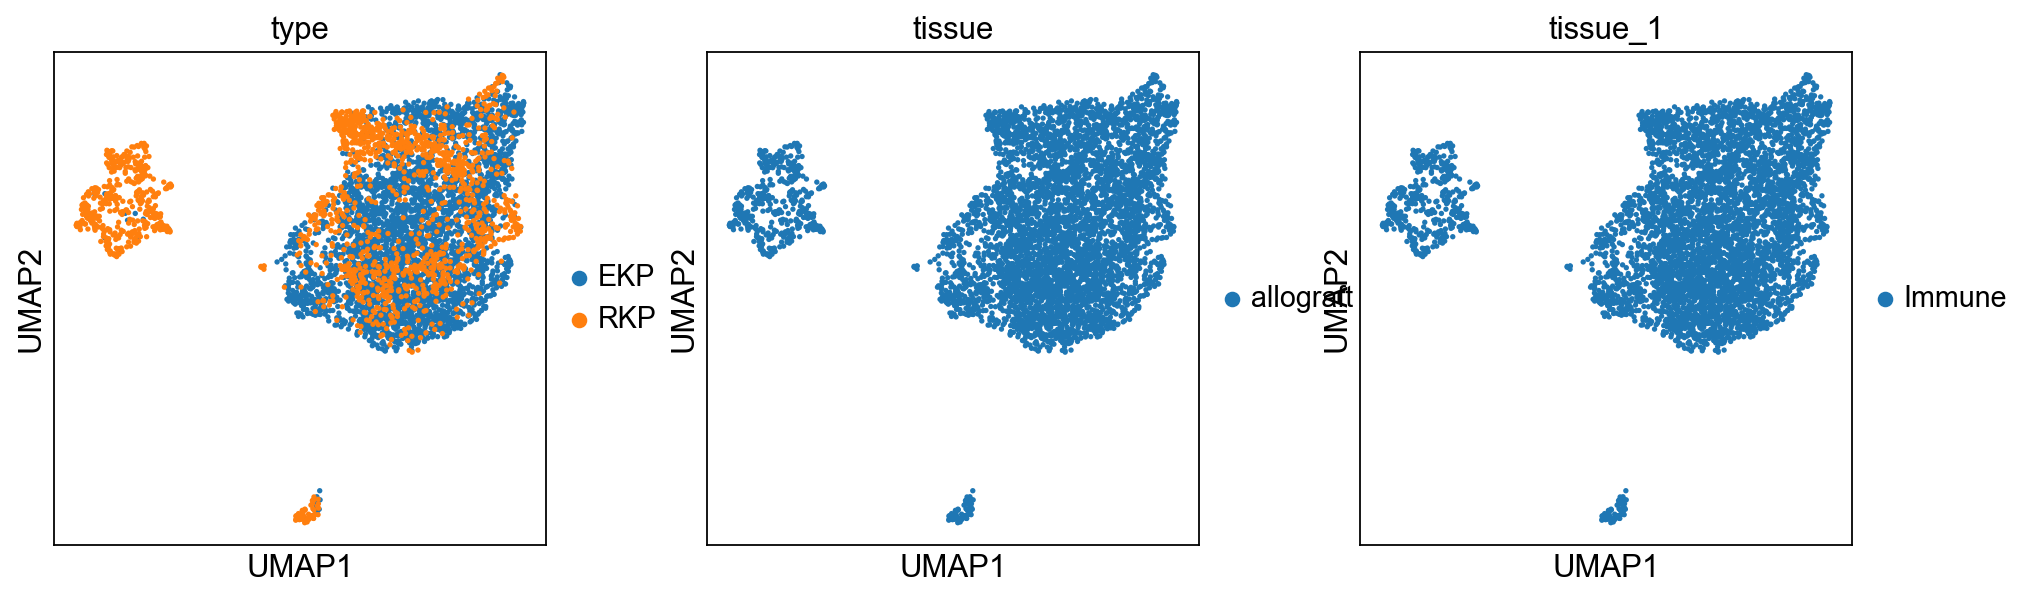

In [76]:
sc.pl.umap(adata, color=['type','tissue','tissue_1'])

In [77]:
#############################################################
############ Harmony batch correction #######################
#############################################################

sce.pp.harmony_integrate(adata, 'batch')
'X_pca_harmony' in adata.obsm
True

2024-04-22 08:55:28,002 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-22 08:55:29,876 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-22 08:55:29,909 - harmonypy - INFO - Iteration 1 of 10
2024-04-22 08:55:31,000 - harmonypy - INFO - Iteration 2 of 10
2024-04-22 08:55:32,082 - harmonypy - INFO - Iteration 3 of 10
2024-04-22 08:55:33,173 - harmonypy - INFO - Iteration 4 of 10
2024-04-22 08:55:34,254 - harmonypy - INFO - Iteration 5 of 10
2024-04-22 08:55:35,104 - harmonypy - INFO - Iteration 6 of 10
2024-04-22 08:55:35,869 - harmonypy - INFO - Iteration 7 of 10
2024-04-22 08:55:36,612 - harmonypy - INFO - Converged after 7 iterations


True

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


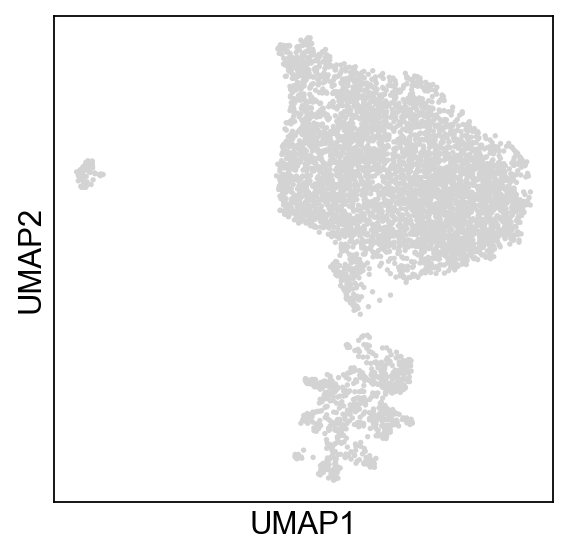

In [78]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata)

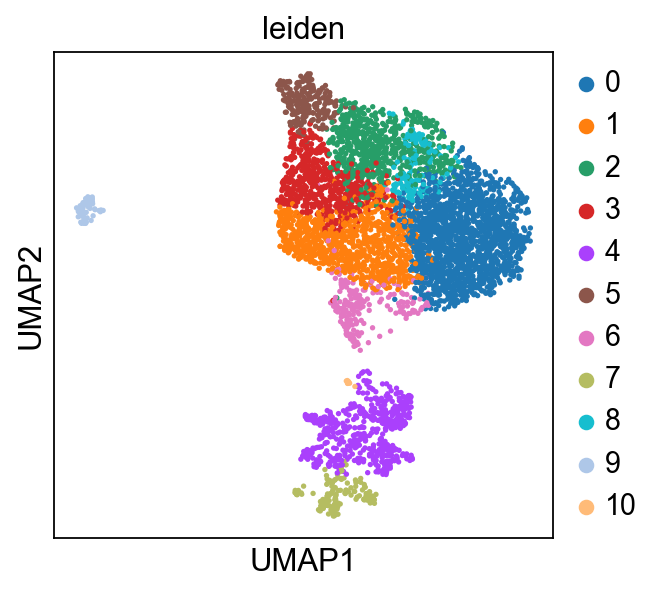

In [79]:
sc.pl.umap(adata, color=['leiden'])

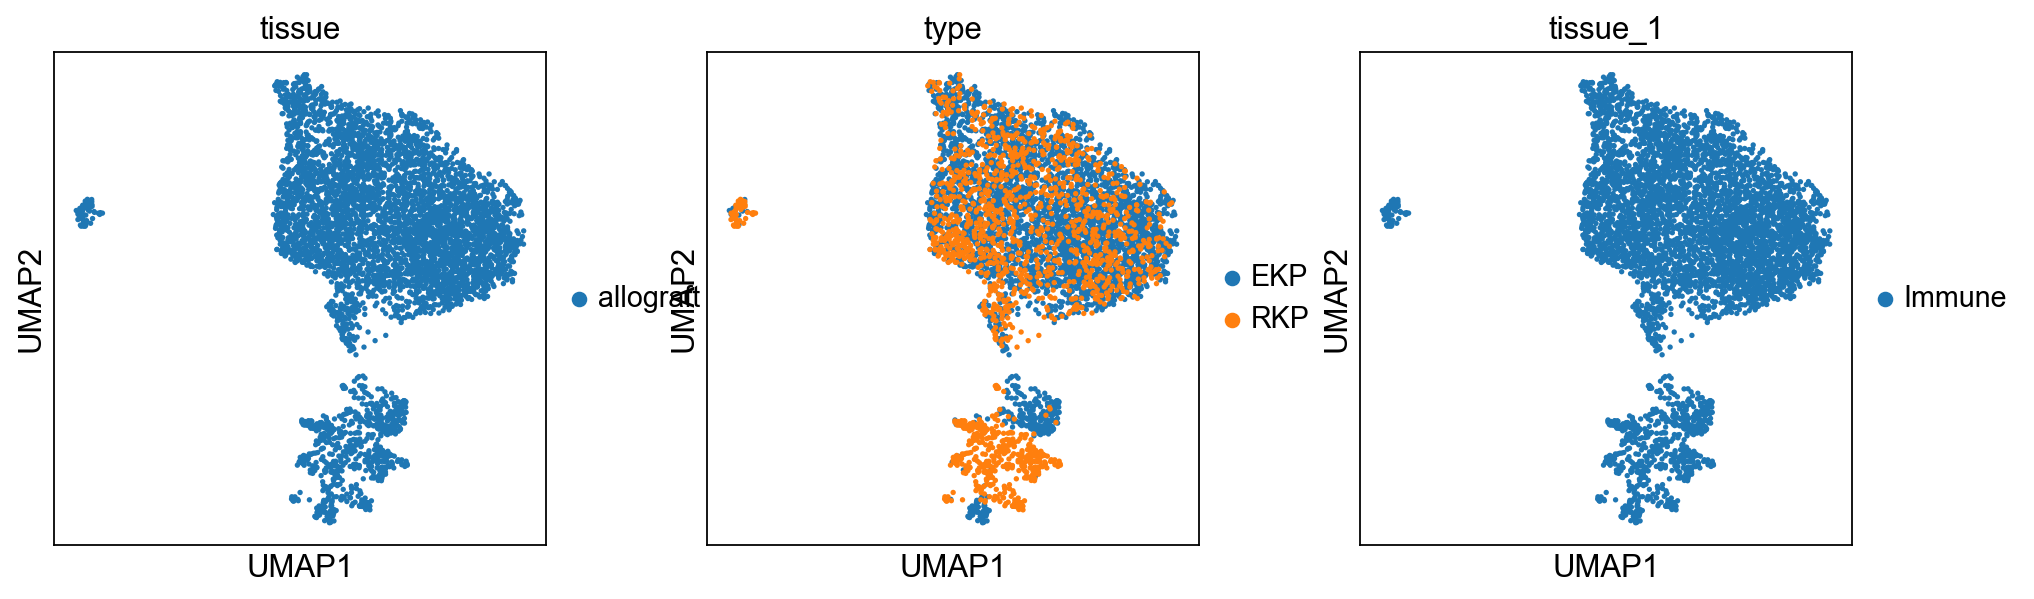

In [80]:
sc.pl.umap(adata, color=['tissue','type','tissue_1'])

In [81]:
df = pd.crosstab(adata.obs['tissue_1'], adata.obs['type'])
df

type       EKP   RKP
tissue_1            
Immune    3481  1659

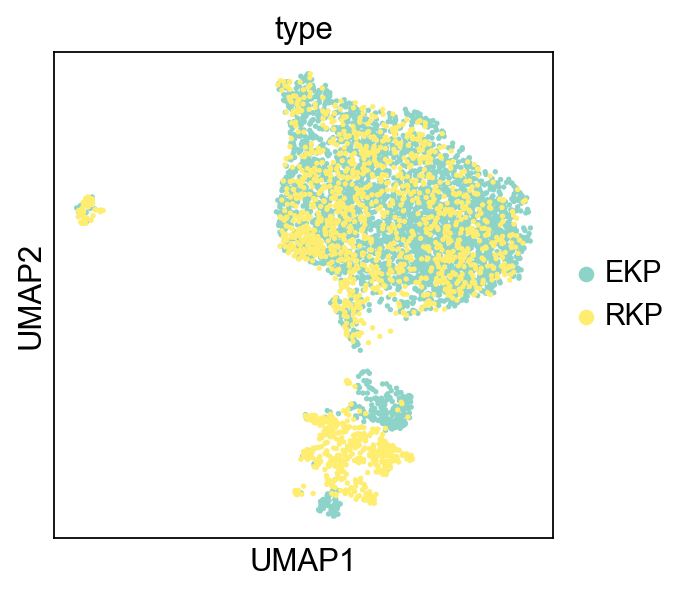

In [82]:
sc.pl.umap(adata, color=['type'],palette="Set3", save='_Immune_cell_by_type_modified.pdf')

In [83]:
adata.obs

n_genes  n_genes_by_counts  total_counts  \
AAACCCACAACACACT-1-0     1224               1220   1482.800415   
AAACCCACAGACTCTA-1-0     1280               1278   1615.358765   
AAACGAACACAACGTT-1-0     1853               1852   1831.287720   
AAACGAACAGACGATG-1-0     1839               1838   1929.874512   
AAACGAAGTTTGGGTT-1-0     1438               1437   1834.701172   
...                       ...                ...           ...   
TTTGACTAGATCGGTG-1-1     2571               2569   2239.192627   
TTTGACTGTTGTGGAG-1-1     1243               1243   1468.334351   
TTTGATCGTGCGTGCT-1-1     1629               1628   1980.749756   
TTTGGAGTCTATCCAT-1-1     2961               2959   2421.421875   
TTTGTTGGTGAGTTTC-1-1     1946               1941   2026.742676   

                      total_counts_mt  pct_counts_mt     tissue type leiden  \
AAACCCACAACACACT-1-0         3.906282       0.263440  allograft  EKP      0   
AAACCCACAGACTCTA-1-0        12.976051       0.803292  allograft  EKP      0   
AAACGAACACAACGTT-1-0        20.704004       1.130571  allograft  EKP      2   
AAACGAACAGACGATG-1-0         0.728869       0.037768  allograft  EKP      1   
AAACGAAGTTTGGGTT-1-0        11.139084       0.607133  allograft  EKP      0   
...                               ...            ...        ...  ...    ...   
TTTGACTAGATCGGTG-1-1        22.420515       1.001277  allograft  RKP      1   
TTTGACTGTTGTGGAG-1-1        26.262447       1.788588  allograft  RKP      1   
TTTGATCGTGCGTGCT-1-1        13.624981       0.687870  allograft  RKP      8   
TTTGGAGTCTATCCAT-1-1        15.085918       0.623019  allograft  RKP      1   
TTTGTTGGTGAGTTTC-1-1        23.481369       1.158577  allograft  RKP      4   

                     batch tissue_1  total_counts_ribo  pct_counts_ribo  \
AAACCCACAACACACT-1-0     0   Immune          23.835543         1.607468   
AAACCCACAGACTCTA-1-0     0   Immune          71.692551         4.438181   
AAACGAACACAACGTT-1-0     0   Immune          73.607811         4.019456   
AAACGAACAGACGATG-1-0     0   Immune          74.001747         3.834537   
AAACGAAGTTTGGGTT-1-0     0   Immune         104.808022         5.712539   
...                    ...      ...                ...              ...   
TTTGACTAGATCGGTG-1-1     1   Immune         137.132645         6.124200   
TTTGACTGTTGTGGAG-1-1     1   Immune          57.621696         3.924290   
TTTGATCGTGCGTGCT-1-1     1   Immune          92.942139         4.692271   
TTTGGAGTCTATCCAT-1-1     1   Immune         150.707428         6.223923   
TTTGTTGGTGAGTTTC-1-1     1   Immune         114.538567         5.651362   

                      total_counts_hb  pct_counts_hb  percent_mt     n_counts  
AAACCCACAACACACT-1-0         0.628129       0.042361    0.002634  1482.800415  
AAACCCACAGACTCTA-1-0         0.000000       0.000000    0.008033  1615.358765  
AAACGAACACAACGTT-1-0         2.079207       0.113538    0.011306  1831.287720  
AAACGAACAGACGATG-1-0         0.000000       0.000000    0.000378  1929.874512  
AAACGAAGTTTGGGTT-1-0         0.000000       0.000000    0.006071  1834.701172  
...                               ...            ...         ...          ...  
TTTGACTAGATCGGTG-1-1         1.049196       0.046856    0.010013  2239.192627  
TTTGACTGTTGTGGAG-1-1         0.733939       0.049984    0.017886  1468.334351  
TTTGATCGTGCGTGCT-1-1         1.662777       0.083947    0.006879  1980.749756  
TTTGGAGTCTATCCAT-1-1         1.764712       0.072879    0.006230  2421.421875  
TTTGTTGGTGAGTTTC-1-1         0.717764       0.035415    0.011586  2026.742676  

[5140 rows x 16 columns]

In [84]:
scv.set_figure_params(style='scvelo', dpi=100, dpi_save=300, frameon=None)

saving figure to file ./figures/scvelo__Immune_scatterplot_by_type.pdf


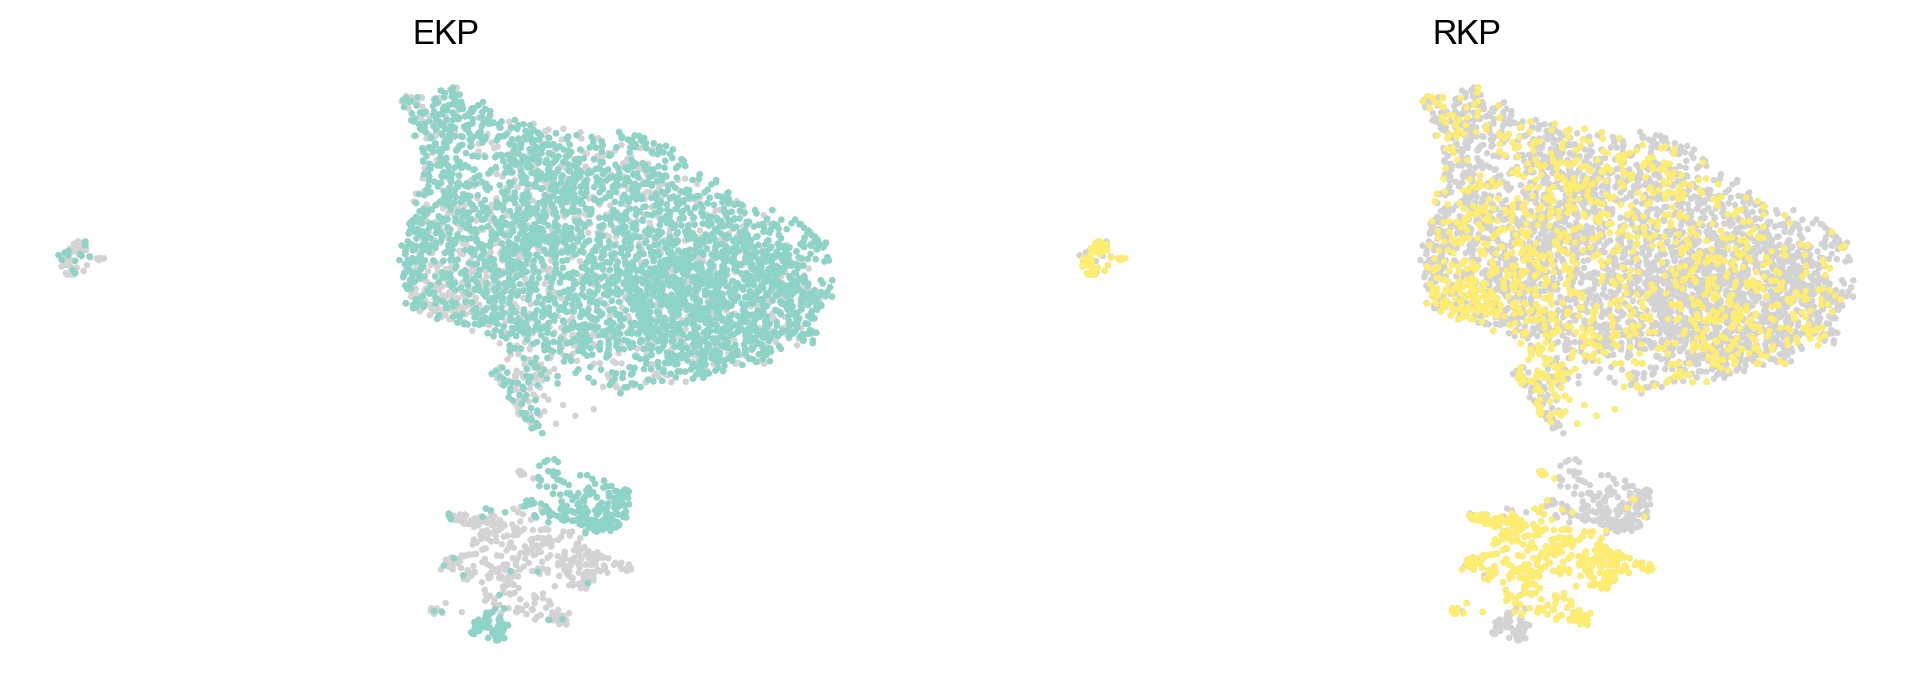

In [85]:
scv.pl.scatter(adata, groups=[[c] for c in adata.obs['type'].cat.categories], color='type', ncols=4, save="_Immune_scatterplot_by_type.pdf")

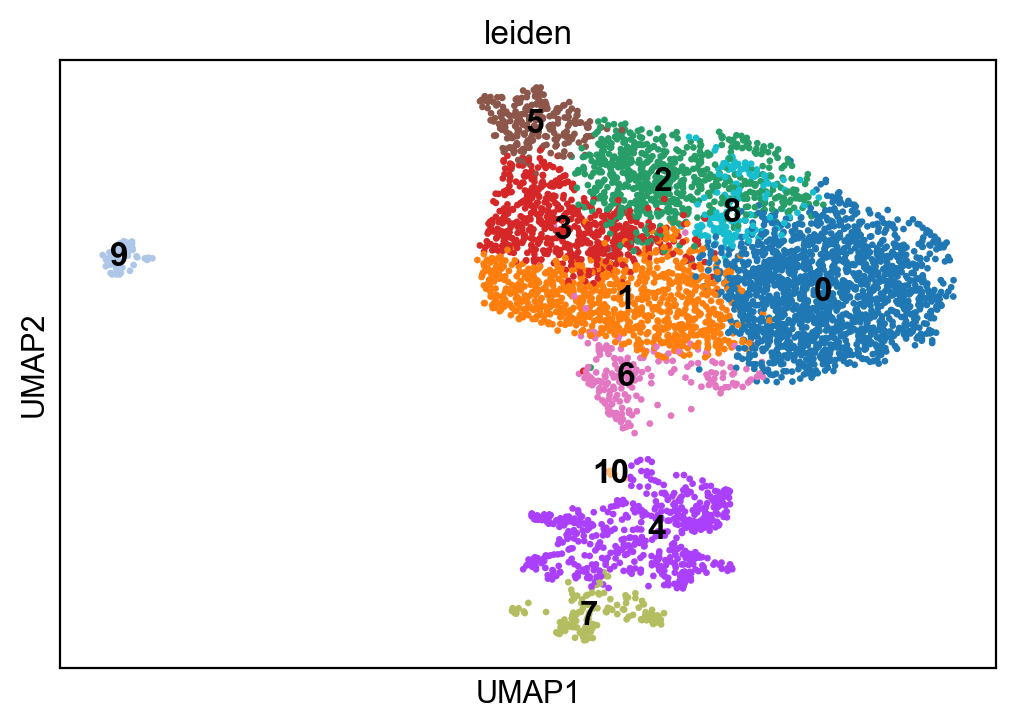

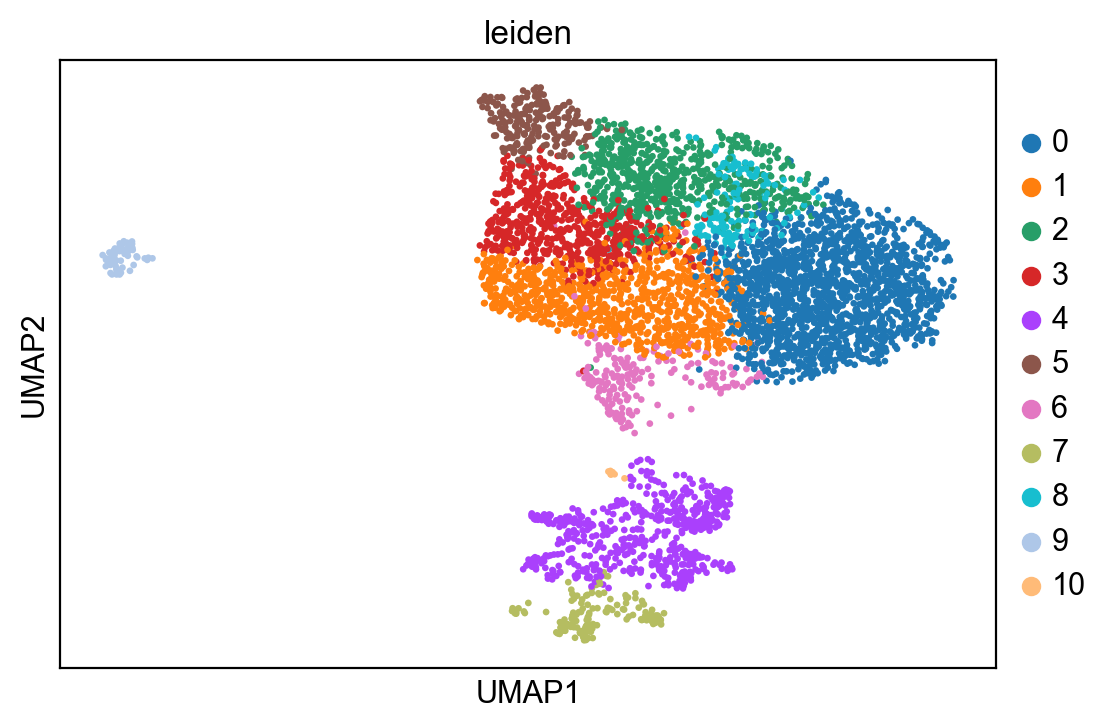

In [86]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')#, save='_Immune_Normal8_NAC15_Tumor15_by_leiden.pdf')
sc.pl.umap(adata, color=['leiden'],legend_loc='right margin')#, save='_Immune_Normal8_NAC15_Tumor15_by_leiden_1.pdf')

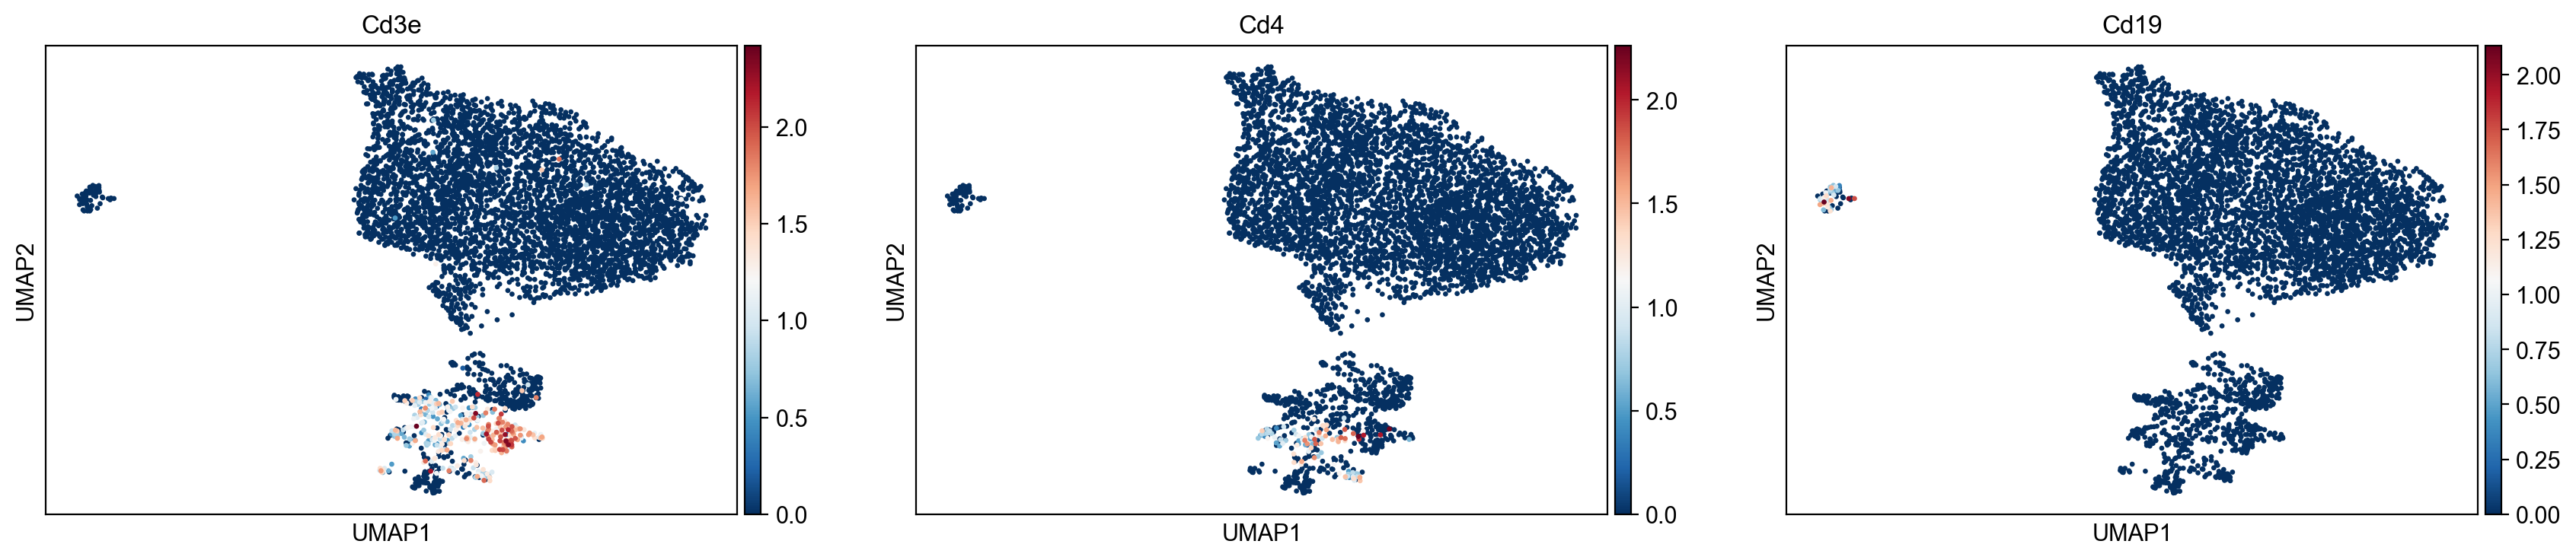

In [87]:
# T cell marker: 'Cd3e','Cd8a','Cd4'
# B cell marker: 'Cd19'
# Myeloid cell marker: 'Itgam','Mrc1'
sc.pl.umap(adata, color=['Cd3e',#'Cd8a',
                      'Cd4','Cd19',
    #'ITGAM','MRC1'
                        ])

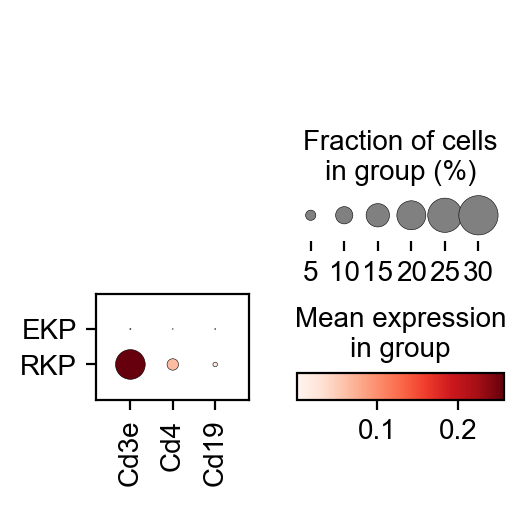

In [88]:
# T cell marker: 'Cd3e','Cd8a','Cd4'
# B cell marker: 'Cd19'
# Myeloid cell marker: 'Itgam','Mrc1'
sc.pl.dotplot(adata, ['Cd3e',#'Cd8a',
                      'Cd4','Cd19',
    #'ITGAM','MRC1'
                     ], groupby='type')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


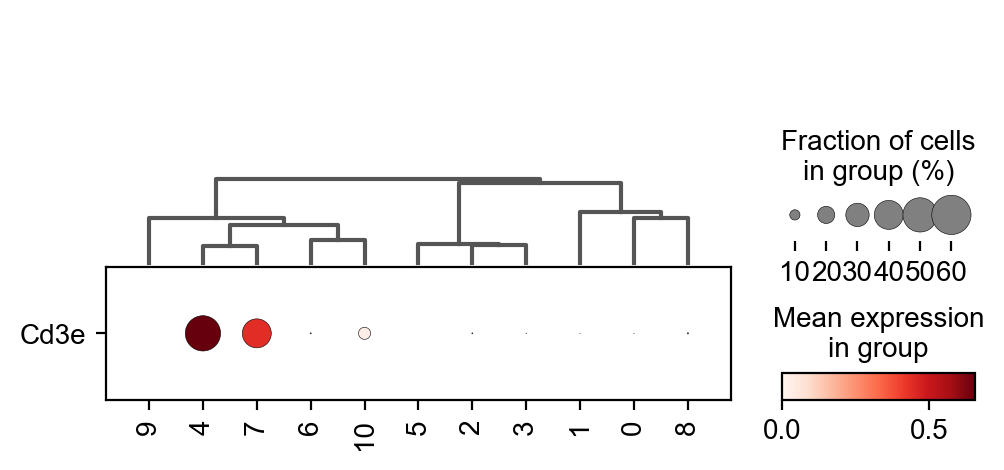

In [89]:
Tcell_geneset = [#'CD3D','CD3G',
    'Cd3e'#,'GZMK'
                ] # T cell
sc.pl.dotplot(adata, Tcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#T cell '4','7','10'

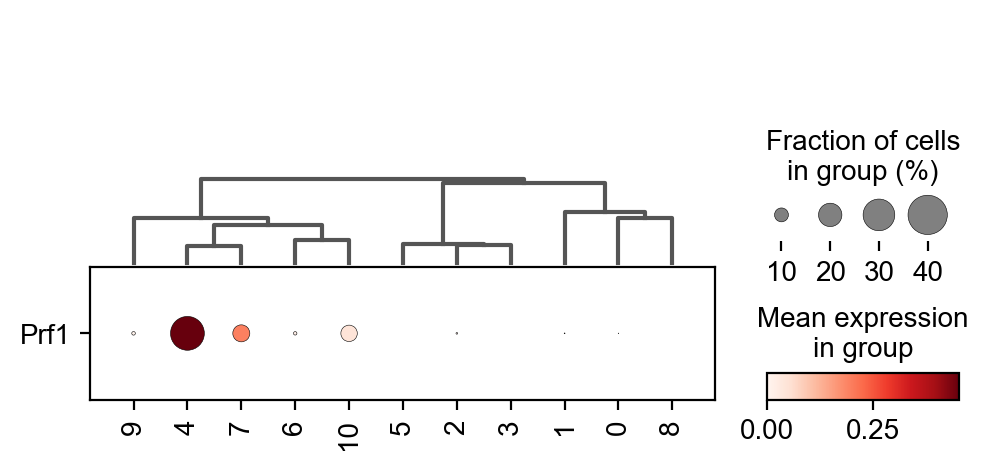

In [142]:
Teffcell_geneset = ['Prf1',
    #'GZMB'
                   ] # effector T cell
sc.pl.dotplot(adata, Teffcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#T effector cell '4'

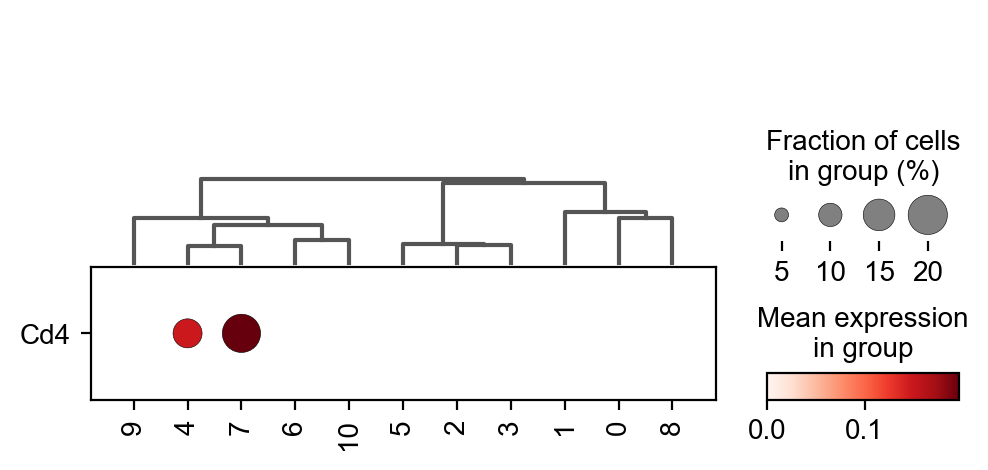

In [143]:
Cd4Tcell_geneset = ['Cd4'] # Cd4 T cell
sc.pl.dotplot(adata, Cd4Tcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#Cd4 T cell '7'

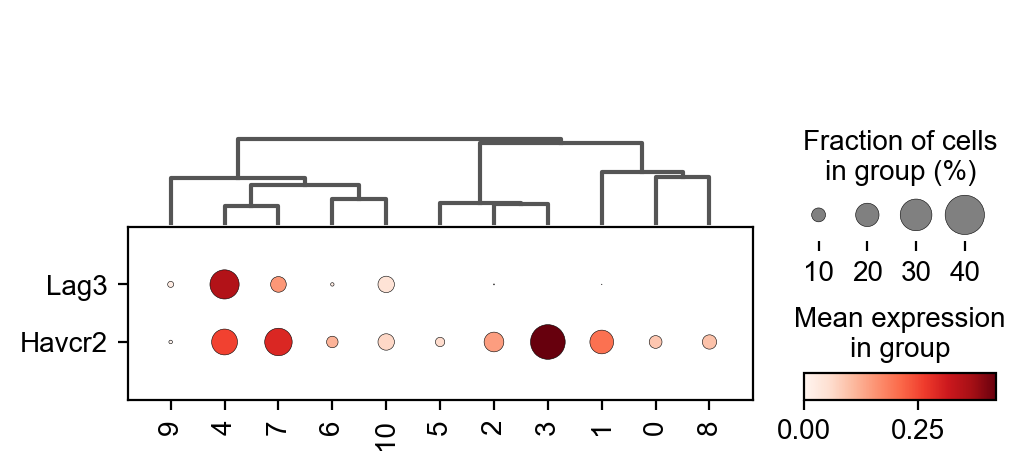

In [92]:
Texcell_geneset = [#'Ctla4','Pdcd1',
    'Lag3','Havcr2'] # exhausted T cell
sc.pl.dotplot(adata, Texcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#T exhausted cell '4','7' look reasonable

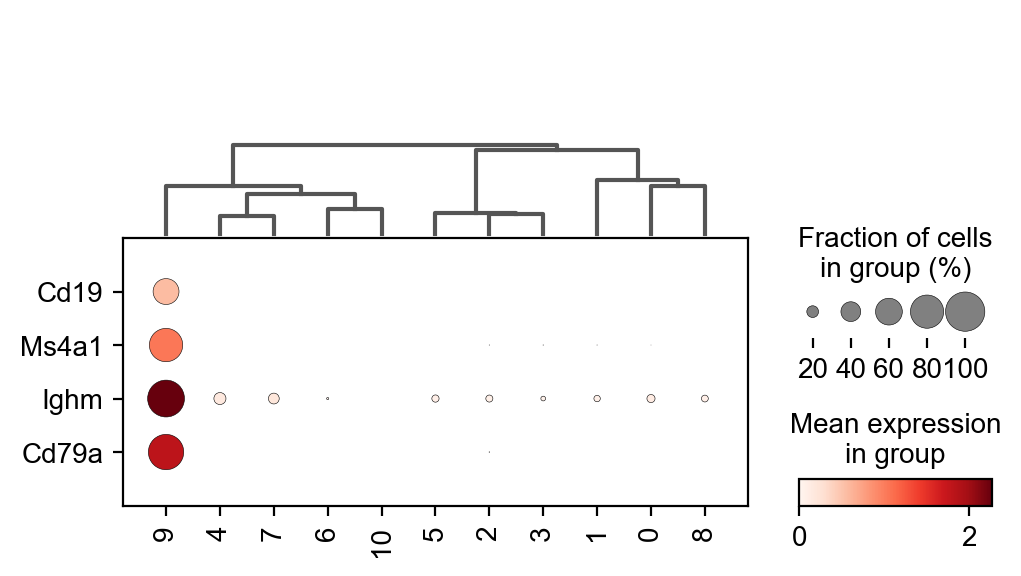

In [93]:
# B cell 
Bcell_geneset =['Cd19','Ms4a1','Ighm','Cd79a'] # B cell
sc.pl.dotplot(adata, Bcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#B cell: '9'

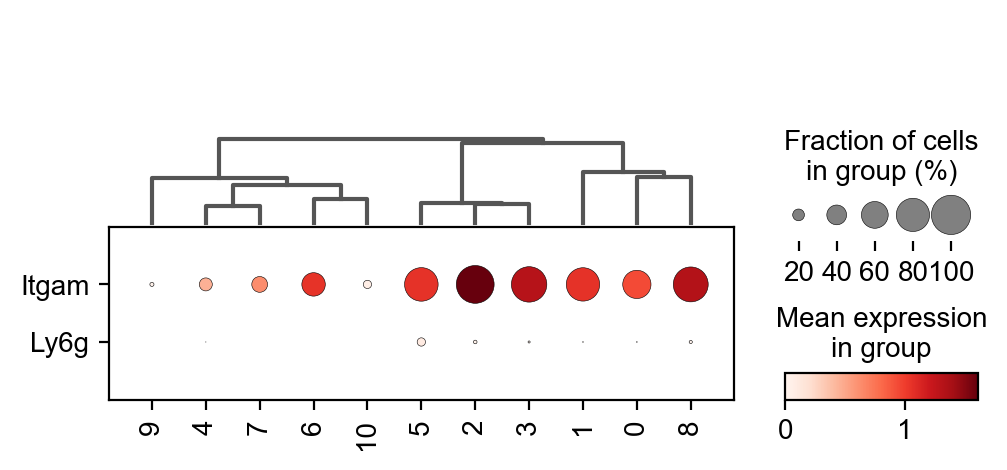

In [116]:
# Myeloid cell 
Myeloidcell_geneset =['Itgam','Ly6g'] # myleoid cell
sc.pl.dotplot(adata, Myeloidcell_geneset , 'leiden', dendrogram=True, swap_axes=True)
#Myeloid cell: '6', '5','2','3','1','0','8'

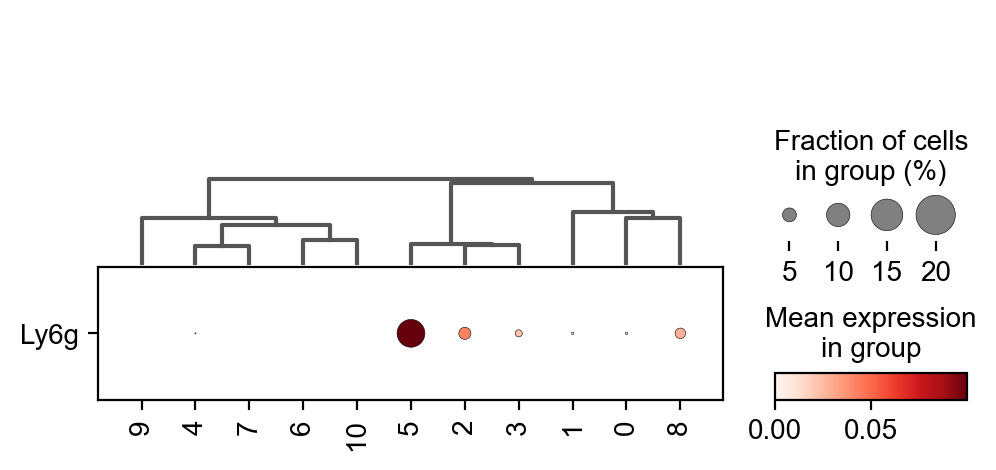

In [122]:
Neutrophil_geneset =['Ly6g'] #Neutrophil
sc.pl.dotplot(adata, Neutrophil_geneset , 'leiden', dendrogram=True, swap_axes=True)

#Neutrophil

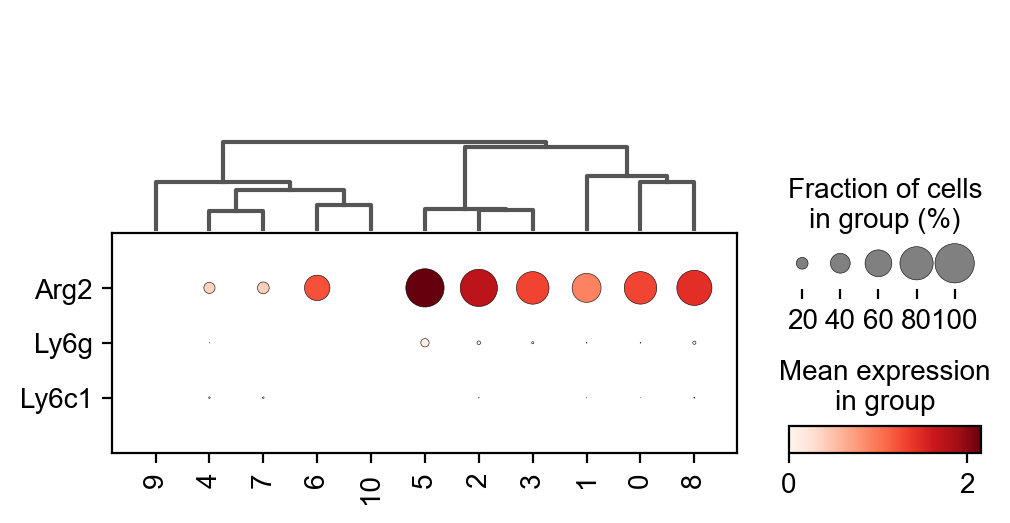

In [124]:
MDSC_geneset =['Arg2','Ly6g','Ly6c1'] #MDSC
sc.pl.dotplot(adata, MDSC_geneset , 'leiden', dendrogram=True, swap_axes=True)

#Neutrophil: 

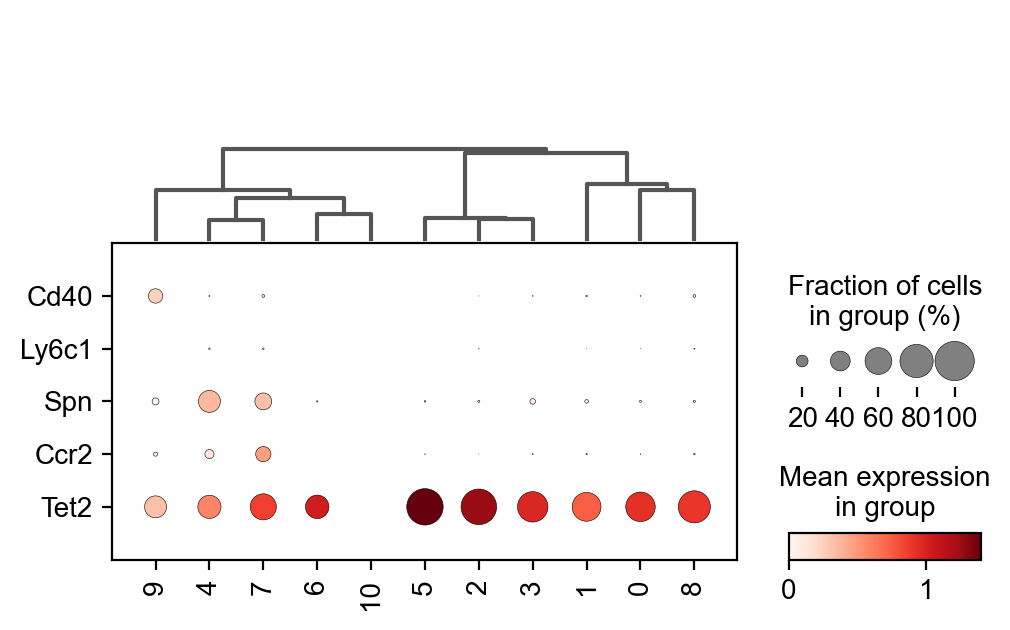

In [121]:
Mono_geneset =['Cd40','Ly6c1','Spn',
               #'Apobec3a',
               'Ccr2',#'Cd11b','Cd115','Cd31',
               'Tet2'
              ] #Monocyte
sc.pl.dotplot(adata, Mono_geneset , 'leiden', dendrogram=True, swap_axes=True)
# SPN = Cd43
#Monocyte '5','2'

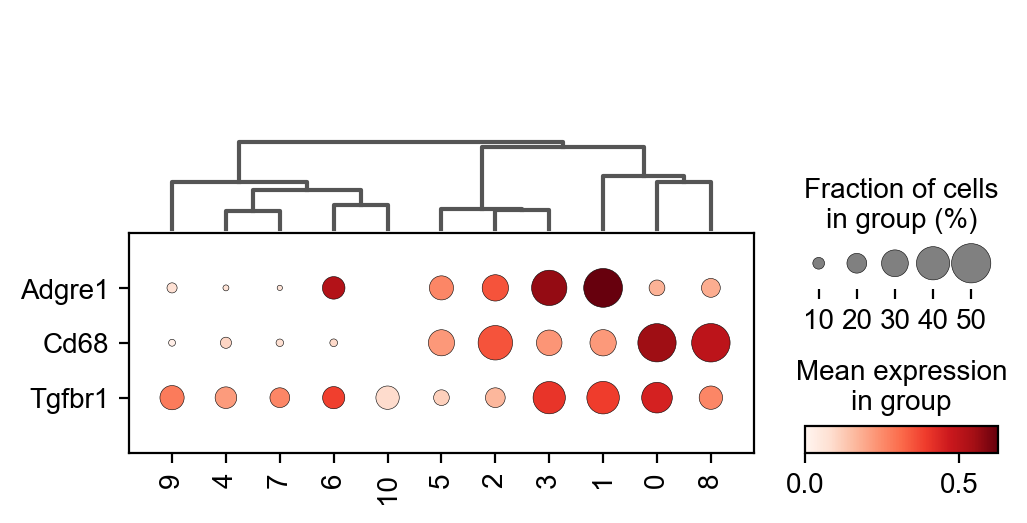

In [127]:
Mac_geneset =['Adgre1','Cd68',#'JAML',
              #'Parp14',#'MARCH1',
              'Tgfbr1'] # Macrophage
sc.pl.dotplot(adata, Mac_geneset , 'leiden', dendrogram=True, swap_axes=True)
#Macro   '6','5','2','3','1','0','8'

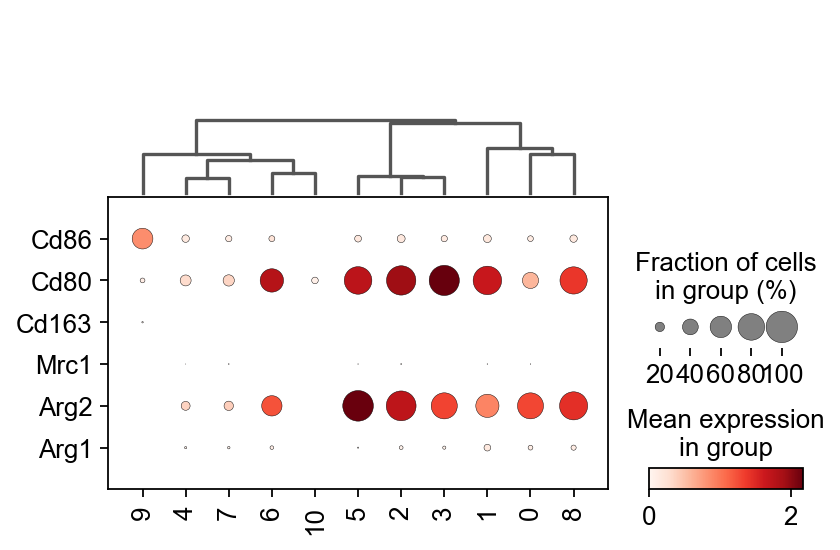

In [6]:
# M1_Macrophage : 'CD64', 'IDO', 'SOCS1', 'CXCL10','CD163','Cd80','Cd86'
# M2_Macrophage : 'MRC1', 'TGM2', 'CD23', 'CCL22'
Mac1_geneset =[#'CXCL10',
    'Cd86','Cd80',
    'Cd163',
    'Mrc1', #'TGM2', 
    #'CCL22'
     'Arg2',
    'Arg1'] 
sc.pl.dotplot(adata, Mac1_geneset , 'leiden', dendrogram=True, swap_axes=True)
#M1 Macro-like '6','3','1'
#M2 Macro-like '5','0',
 

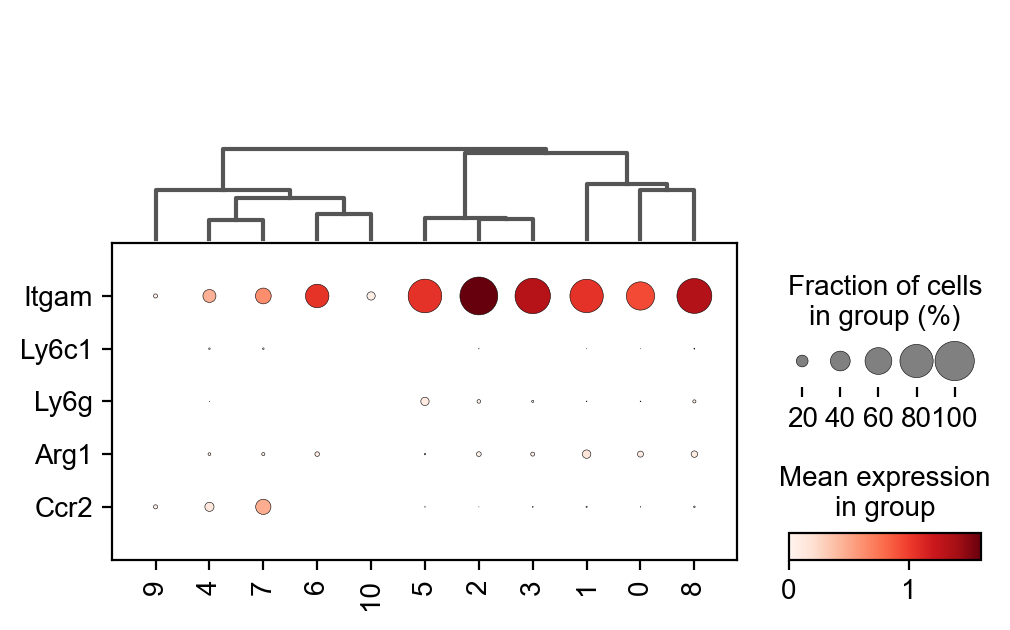

In [139]:
MDSC_geneset =['Itgam','Ly6c1','Ly6g',#'Cd115',
               'Arg1','Ccr2'
              ] #MDSC
sc.pl.dotplot(adata, MDSC_geneset , 'leiden', dendrogram=True, swap_axes=True)
#MDSC 

In [ ]:
Mast_geneset =['Cd117','cd23',
              ] # Mast cell
sc.pl.dotplot(adata, Mast_geneset , 'leiden', dendrogram=True, swap_axes=True)
#Mast cell

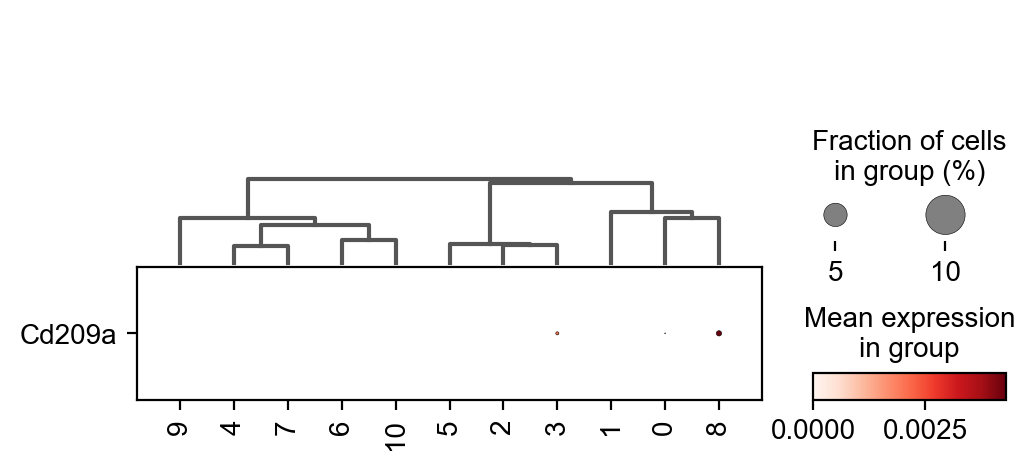

In [114]:
DC_geneset =['Cd209a',
    #'Cd11c'#,'TREM2'
            ] #Monocyte
sc.pl.dotplot(adata, DC_geneset , 'leiden', dendrogram=True, swap_axes=True)
#DC 

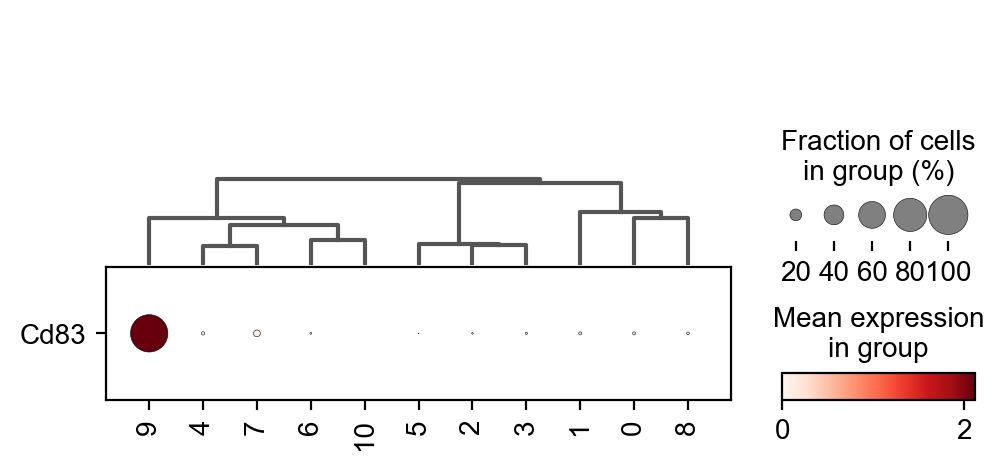

In [134]:
Plasma_geneset =[#'Cd317',
    'Cd83'
                ] 
sc.pl.dotplot(adata, Plasma_geneset , 'leiden', dendrogram=True, swap_axes=True)
#Plasma 

In [ ]:
eosino_geneset =['Cd193'] 
sc.pl.dotplot(adata, eosino_geneset , 'leiden', dendrogram=True, swap_axes=True)
#eosinophil 

In [141]:
#for cell type annotation
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', use_raw=True,  key_added = "leiden_rank_fgsea")
result = adata.uns['leiden_rank_fgsea']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:5]: result[key][group]
    for group in groups for key in ['names', 'scores','logfoldchanges', 'pvals', 'pvals_adj']}).to_csv("D:/KP/EKP_RKP/Immune__DEG_by_leiden_for_annotation_04-22-24.csv")
# logFC becomes negative or disappear when use_raw=False, could be Scanpy bug


ranking genes
    finished: added to `.uns['leiden_rank_fgsea']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


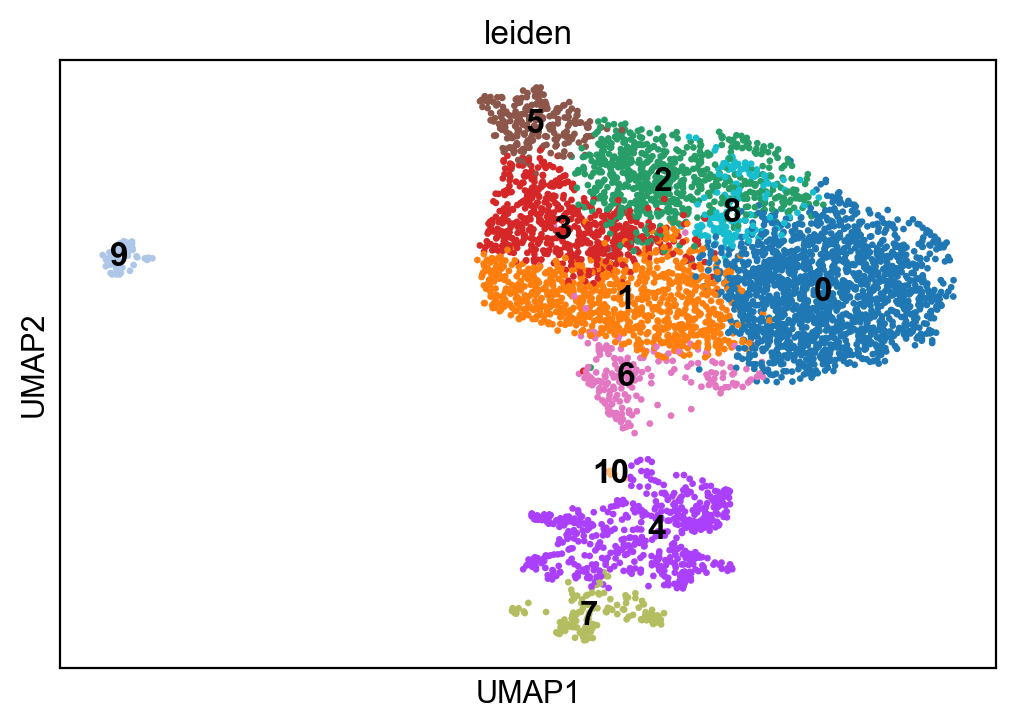

In [140]:
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')#, save='_Immune_Normal_NAC_Tumor_by_leiden.pdf')

In [ ]:
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = {'T cell':      ['10'],
             'Cd8 T cell': ['4'],
             'Cd4 T cell': ['7'],
             'B cell':    ['9'],
             'Monocyte':  ['2','8'],
             
             'M1_Macrophage': ['6','3','1'],
             'M2_Macrophage': ['5','0']

            }

# Initialize empty column in cell metadata
adata.obs['celltype'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'celltype'] = i

sc.pl.umap(adata, color=['celltype'], legend_loc='right margin', legend_fontsize=6)#, save='_Immune_cells_by_celltype.pdf')


In [145]:
df = pd.crosstab(adata.obs['celltype'], adata.obs['type'])
df

type            EKP  RKP
celltype                
B cell           13   48
Cd4 T cell       63   82
Cd8 T cell      215  331
M1_Macrophage  1091  556
M2_Macrophage  1517  400
Macrophage      582  234
T cell            0    8

In [146]:
adata.write('Immune_cell_after_harmony_04-22-24.h5ad', compression='gzip')

In [5]:
adata = sc.read('Immune_cell_after_harmony_04-22-24.h5ad')

In [147]:
adata.var

gene_ids_2  feature_types_2   mt_2  n_cells_2-0  \
Mrpl15          ENSMUSG00000033845  Gene Expression  False          489   
Lypla1          ENSMUSG00000025903  Gene Expression  False          753   
Tcea1           ENSMUSG00000033813  Gene Expression  False         1096   
Atp6v1h         ENSMUSG00000033793  Gene Expression  False         1521   
Rb1cc1          ENSMUSG00000025907  Gene Expression  False         1977   
...                            ...              ...    ...          ...   
Csprs           ENSMUSG00000062783  Gene Expression  False           17   
Vamp7           ENSMUSG00000051412  Gene Expression  False          280   
Tmlhe           ENSMUSG00000079834  Gene Expression  False           45   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression  False           48   
AC149090.1      ENSMUSG00000095041  Gene Expression  False          582   

                n_cells_by_counts_2-0  mean_counts_2-0  \
Mrpl15                            489         0.174057   
Lypla1                            753         0.292388   
Tcea1                            1096         0.582167   
Atp6v1h                          1521         0.959450   
Rb1cc1                           1977         1.086080   
...                               ...              ...   
Csprs                              17         0.004031   
Vamp7                             280         0.100071   
Tmlhe                              45         0.020631   
CAAA01147332.1                     48         0.012568   
AC149090.1                        582         0.291439   

                pct_dropout_by_counts_2-0  total_counts_2-0  n_cells_2-1  \
Mrpl15                          88.404079             734.0          503   
Lypla1                          82.143704            1233.0          576   
Tcea1                           74.009960            2455.0          996   
Atp6v1h                         63.931705            4046.0          740   
Rb1cc1                          53.118331            4580.0          917   
...                                   ...               ...          ...   
Csprs                           99.596870              17.0           33   
Vamp7                           93.360209             422.0          315   
Tmlhe                           98.932891              87.0           96   
CAAA01147332.1                  98.861750              53.0           69   
AC149090.1                      86.198719            1229.0          684   

                n_cells_by_counts_2-1  ...  total_counts_2-1     mt   ribo  \
Mrpl15                            503  ...             738.0  False  False   
Lypla1                            576  ...             817.0  False  False   
Tcea1                             996  ...            2067.0  False  False   
Atp6v1h                           740  ...            1424.0  False  False   
Rb1cc1                            917  ...            1876.0  False  False   
...                               ...  ...               ...    ...    ...   
Csprs                              33  ...              36.0  False  False   
Vamp7                             315  ...             428.0  False  False   
Tmlhe                              96  ...             158.0  False  False   
CAAA01147332.1                     69  ...              72.0  False  False   
AC149090.1                        684  ...            1782.0  False  False   

                   hb  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Mrpl15          False                500     0.065387              90.272374   
Lypla1          False                821     0.121859              84.027237   
Tcea1           False               1197     0.191426              76.712062   
Atp6v1h         False               1598     0.336518              68.910506   
Rb1cc1          False               2237     0.440159              56.478599   
...               ...                ...          ...                    ...   
Csprs           

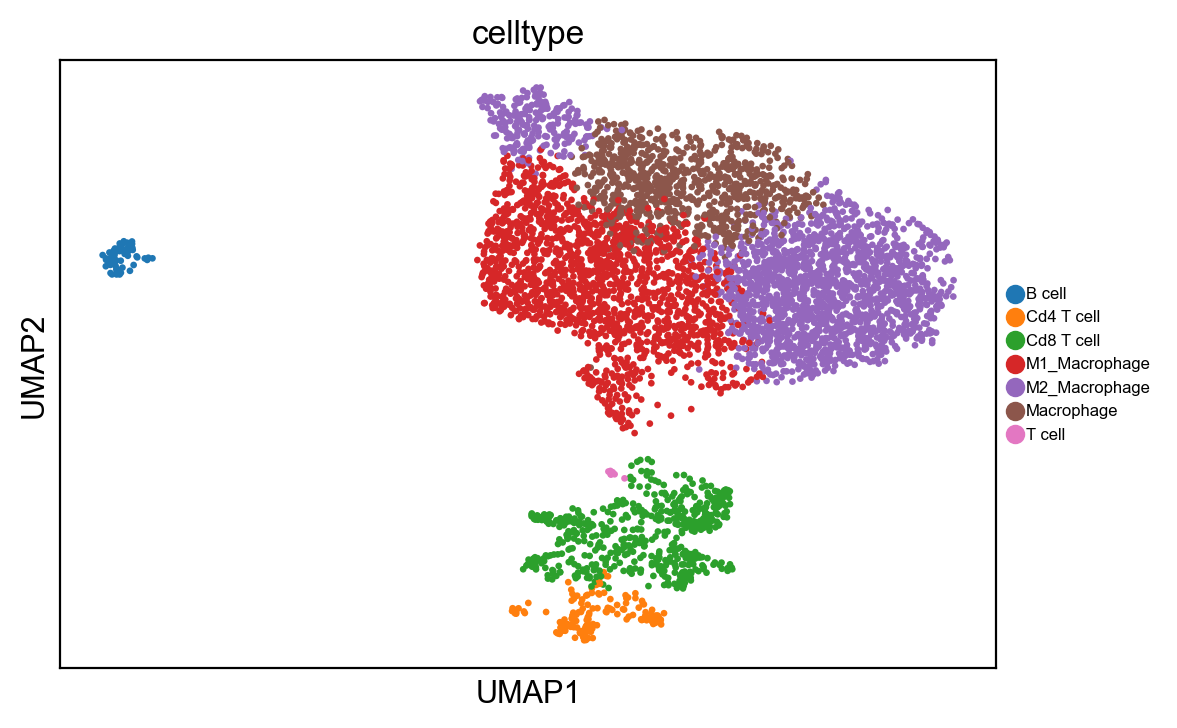

In [148]:
sc.pl.umap(adata, color=['celltype'], legend_loc='right margin', legend_fontsize=6, save='_Immune_cells_by_celltype.pdf')

saving figure to file ./figures/scvelo__Immune_scatterplot_by_type.pdf


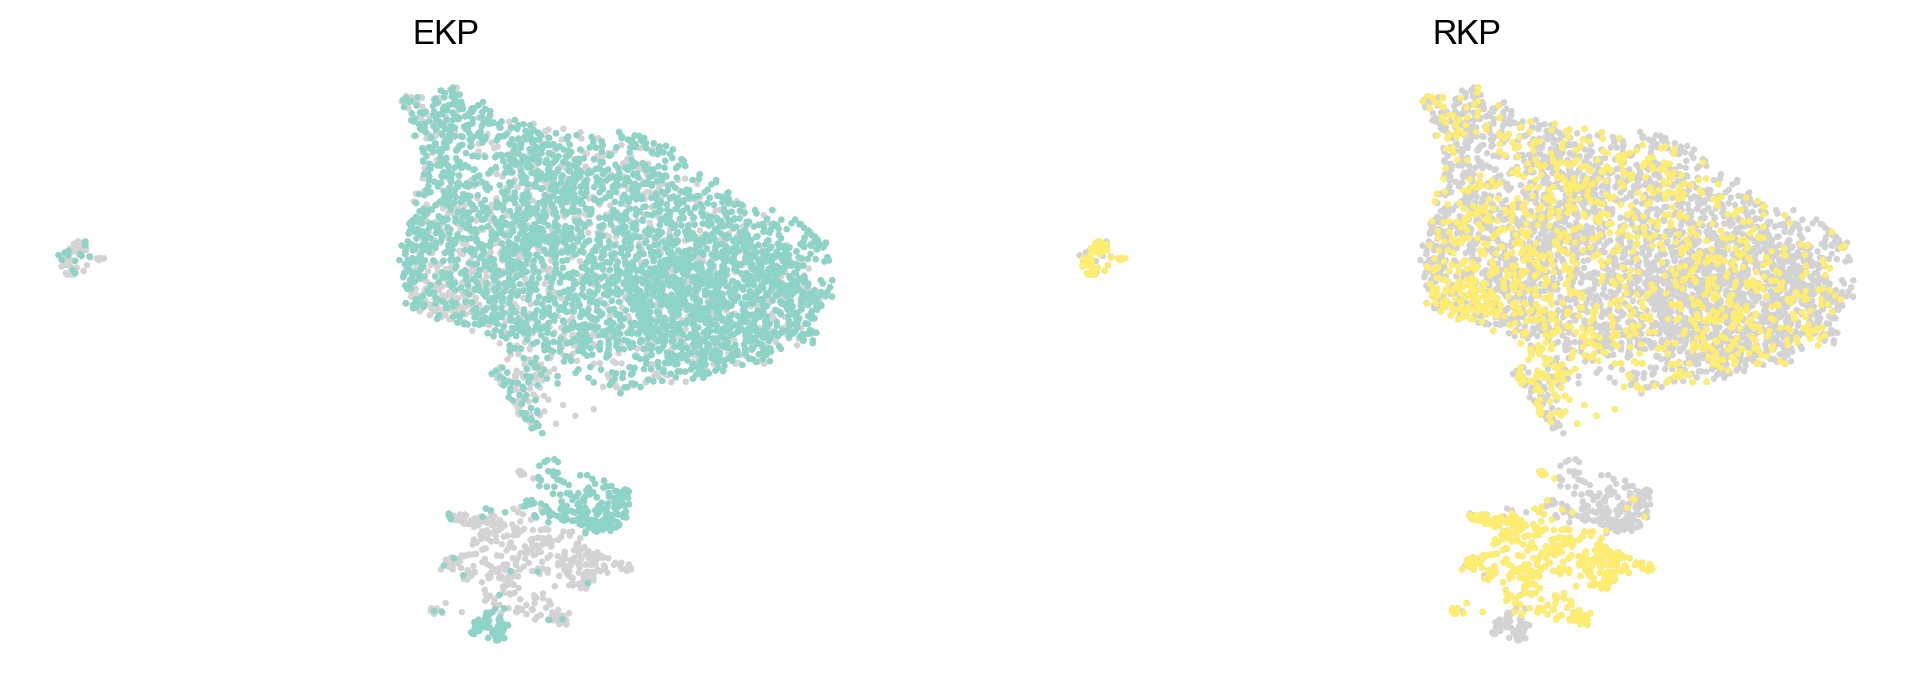

In [150]:
scv.pl.scatter(adata, groups=[[c] for c in adata.obs['type'].cat.categories], color='type', ncols=4, save="_Immune_scatterplot_by_type.pdf")

saving figure to file ./figures/scvelo__Immune_scatterplot_by_celltype.pdf


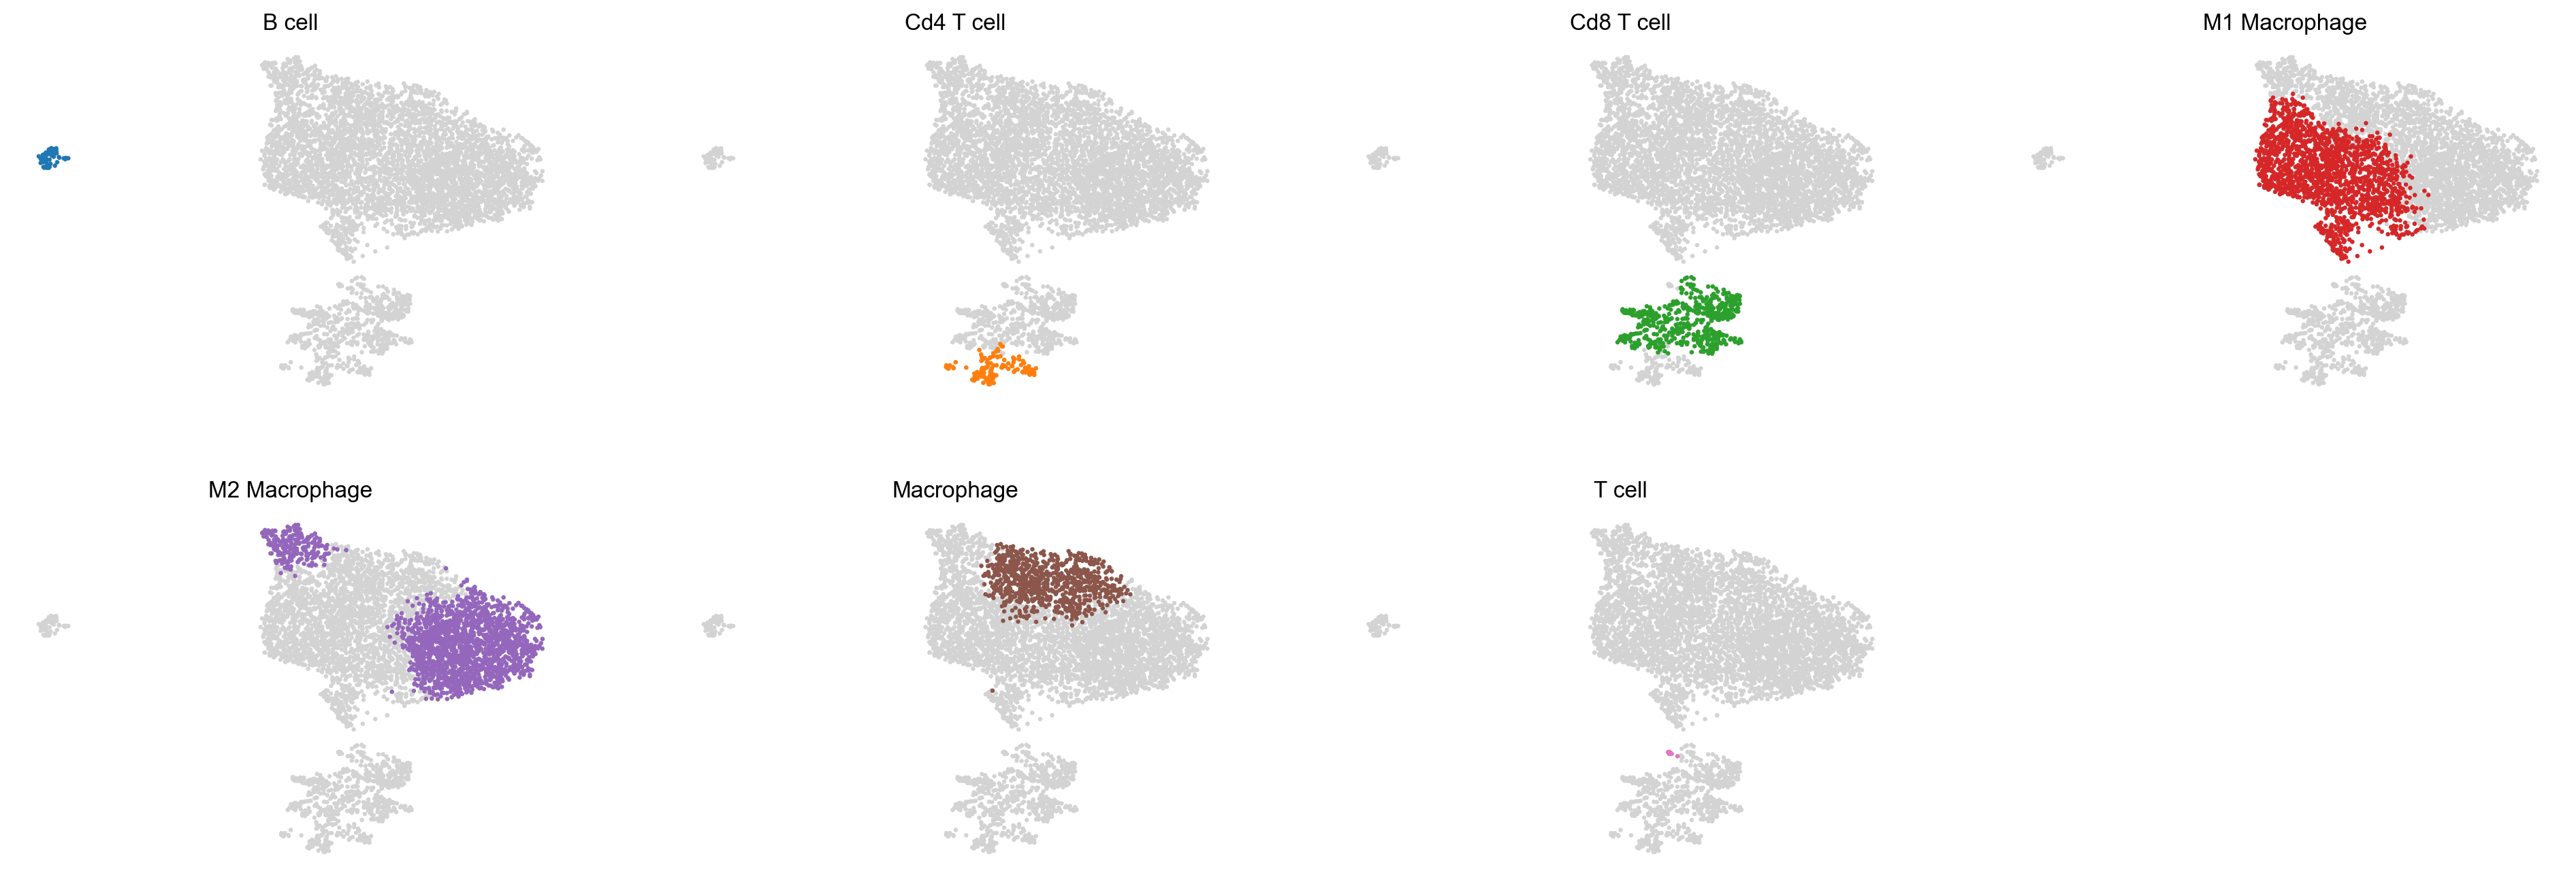

In [151]:
# Previous result
scv.pl.scatter(adata, groups=[[c] for c in adata.obs['celltype'].cat.categories], color='celltype', ncols=4, save="_Immune_scatterplot_by_celltype.pdf")

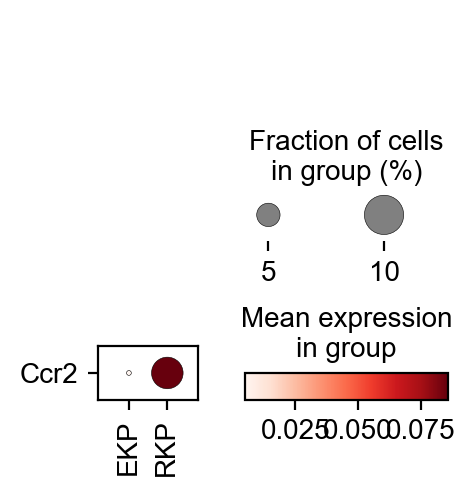

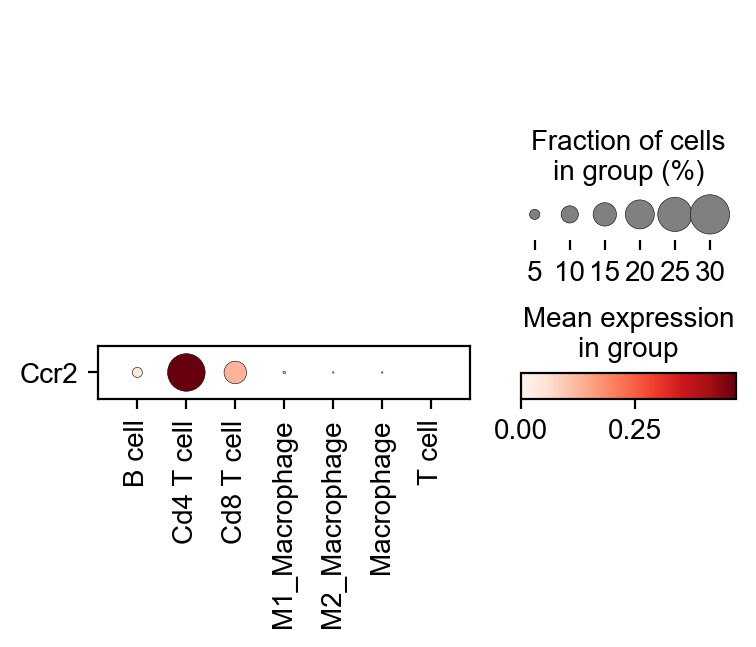

In [153]:
sc.pl.dotplot(adata, ['Ccr2'], groupby='type', swap_axes=True)
sc.pl.dotplot(adata, ['Ccr2'], groupby='celltype', swap_axes=True)

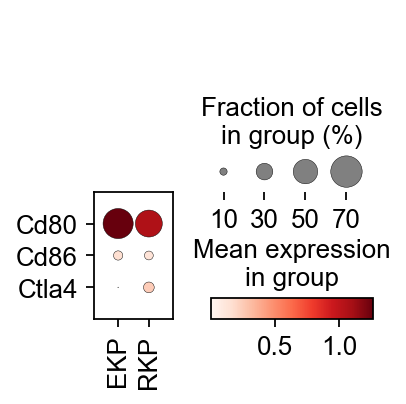

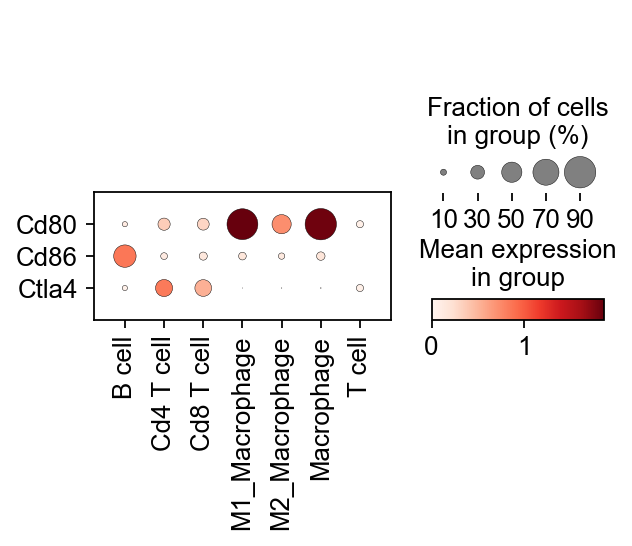

In [15]:
sc.pl.dotplot(adata, ['Cd80','Cd86','Ctla4'], groupby='type', swap_axes=True)
sc.pl.dotplot(adata, ['Cd80','Cd86','Ctla4'], groupby='celltype', swap_axes=True, save='_Cd80_Cd86_Ctla4_by_celltype.pdf')

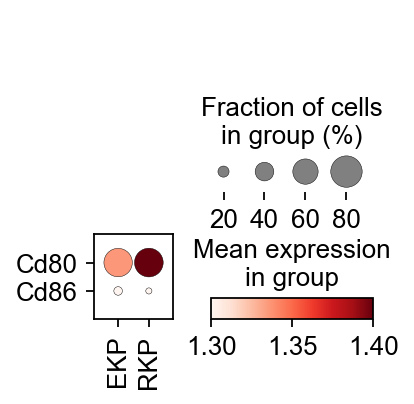

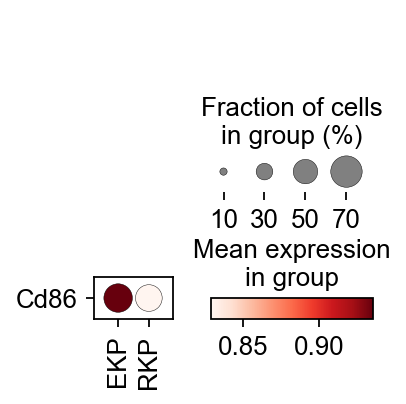

In [16]:
sc.pl.dotplot(adata[adata.obs['celltype'].isin(['M1_Macrophage','M2_Macrophage','Macrophage'])], ['Cd80','Cd86'], groupby='type',vmin=1.3,vmax=1.4, swap_axes=True, save='_Cd80_Cd86_in_Macrophages.pdf')
sc.pl.dotplot(adata[adata.obs['celltype'].isin(['B cell'])], ['Cd86'], groupby='type', swap_axes=True)

In [18]:
adata.obs

n_genes  n_genes_by_counts  total_counts  \
AAACCCACAACACACT-1-0     1224               1220   1482.800415   
AAACCCACAGACTCTA-1-0     1280               1278   1615.358765   
AAACGAACACAACGTT-1-0     1853               1852   1831.287720   
AAACGAACAGACGATG-1-0     1839               1838   1929.874512   
AAACGAAGTTTGGGTT-1-0     1438               1437   1834.701172   
...                       ...                ...           ...   
TTTGACTAGATCGGTG-1-1     2571               2569   2239.192627   
TTTGACTGTTGTGGAG-1-1     1243               1243   1468.334351   
TTTGATCGTGCGTGCT-1-1     1629               1628   1980.749756   
TTTGGAGTCTATCCAT-1-1     2961               2959   2421.421875   
TTTGTTGGTGAGTTTC-1-1     1946               1941   2026.742676   

                      total_counts_mt  pct_counts_mt     tissue type leiden  \
AAACCCACAACACACT-1-0         3.906282       0.263440  allograft  EKP      0   
AAACCCACAGACTCTA-1-0        12.976051       0.803292  allograft  EKP      0   
AAACGAACACAACGTT-1-0        20.704004       1.130571  allograft  EKP      2   
AAACGAACAGACGATG-1-0         0.728869       0.037768  allograft  EKP      1   
AAACGAAGTTTGGGTT-1-0        11.139084       0.607133  allograft  EKP      0   
...                               ...            ...        ...  ...    ...   
TTTGACTAGATCGGTG-1-1        22.420515       1.001277  allograft  RKP      1   
TTTGACTGTTGTGGAG-1-1        26.262447       1.788588  allograft  RKP      1   
TTTGATCGTGCGTGCT-1-1        13.624981       0.687870  allograft  RKP      8   
TTTGGAGTCTATCCAT-1-1        15.085918       0.623019  allograft  RKP      1   
TTTGTTGGTGAGTTTC-1-1        23.481369       1.158577  allograft  RKP      4   

                     batch tissue_1  total_counts_ribo  pct_counts_ribo  \
AAACCCACAACACACT-1-0     0   Immune          23.835543         1.607468   
AAACCCACAGACTCTA-1-0     0   Immune          71.692551         4.438181   
AAACGAACACAACGTT-1-0     0   Immune          73.607811         4.019456   
AAACGAACAGACGATG-1-0     0   Immune          74.001747         3.834537   
AAACGAAGTTTGGGTT-1-0     0   Immune         104.808022         5.712539   
...                    ...      ...                ...              ...   
TTTGACTAGATCGGTG-1-1     1   Immune         137.132645         6.124200   
TTTGACTGTTGTGGAG-1-1     1   Immune          57.621696         3.924290   
TTTGATCGTGCGTGCT-1-1     1   Immune          92.942139         4.692271   
TTTGGAGTCTATCCAT-1-1     1   Immune         150.707428         6.223923   
TTTGTTGGTGAGTTTC-1-1     1   Immune         114.538567         5.651362   

                      total_counts_hb  pct_counts_hb  percent_mt     n_counts  \
AAACCCACAACACACT-1-0         0.628129       0.042361    0.002634  1482.800415   
AAACCCACAGACTCTA-1-0         0.000000       0.000000    0.008033  1615.358765   
AAACGAACACAACGTT-1-0         2.079207       0.113538    0.011306  1831.287720   
AAACGAACAGACGATG-1-0         0.000000       0.000000    0.000378  1929.874512   
AAACGAAGTTTGGGTT-1-0         0.000000       0.000000    0.006071  1834.701172   
...                               ...            ...         ...          ...   
TTTGACTAGATCGGTG-1-1         1.049196       0.046856    0.010013  2239.192627   
TTTGACTGTTGTGGAG-1-1         0.733939       0.049984    0.017886  1468.334351   
TTTGATCGTGCGTGCT-1-1         1.662777       0.083947    0.006879  1980.749756   
TTTGGAGTCTATCCAT-1-1         1.764712       0.072879    0.006230  2421.421875   
TTTGTTGGTGAGTTTC-1-1         0.717764       0.035415    0.011586  2026.742676   

                           celltype  
AAACCCACAACACACT-1-0  M2_Macrophage  
AAACCCACAGACTCTA-1-0  M2_Macrophage  
AAACGAACACAACGTT-1-0     Macrophage  
AAACGAACAGACGATG-1-0  M1_Macrophage  
AAACGAAGTTTGGGTT-1-0  M2_Macrophage  
...                             ...  
TTTGACTAGATCGGTG-1-1  M1_Macrophage  
TTTGACTGTTGTGGAG-1-1  M1_Macrophage  
TTTGATCGTGCGTGCT-1-1     Macrophage  
TTTGGAGTCTATCCAT-1-1  M1_M

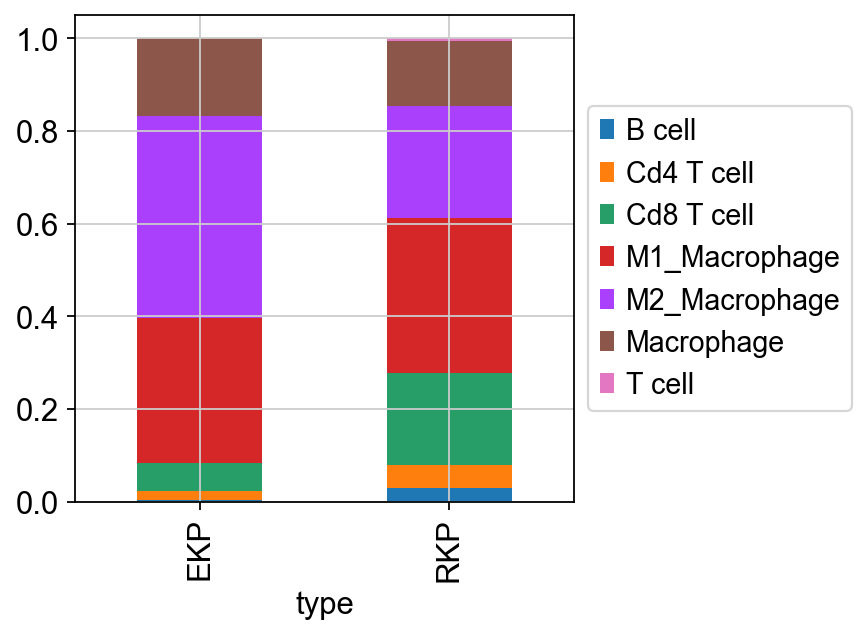

In [22]:
tmp = pd.crosstab(adata.obs['type'],adata.obs['celltype'], normalize='index')
ax = tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5)).get_figure()

ax.savefig('all_immune_cell_stacked_bar.pdf')

In [21]:
tmp

celltype    B cell  Cd4 T cell  Cd8 T cell  M1_Macrophage  M2_Macrophage  \
type                                                                       
EKP       0.003735    0.018098    0.061764       0.313416       0.435794   
RKP       0.028933    0.049427    0.199518       0.335142       0.241109   

celltype  Macrophage    T cell  
type                            
EKP         0.167193  0.000000  
RKP         0.141049  0.004822

In [ ]:
sc.pl.dotplot(adata, ['Foxp3'], groupby='type', swap_axes=True)
sc.pl.dotplot(adata, ['Foxp3'], groupby='celltype', swap_axes=True)

In [11]:
adata.obs['celltype']

AAACCCACAACACACT-1-0    M2_Macrophage
AAACCCACAGACTCTA-1-0    M2_Macrophage
AAACGAACACAACGTT-1-0       Macrophage
AAACGAACAGACGATG-1-0    M1_Macrophage
AAACGAAGTTTGGGTT-1-0    M2_Macrophage
                            ...      
TTTGACTAGATCGGTG-1-1    M1_Macrophage
TTTGACTGTTGTGGAG-1-1    M1_Macrophage
TTTGATCGTGCGTGCT-1-1       Macrophage
TTTGGAGTCTATCCAT-1-1    M1_Macrophage
TTTGTTGGTGAGTTTC-1-1       Cd8 T cell
Name: celltype, Length: 5140, dtype: category
Categories (7, object): ['B cell', 'Cd4 T cell', 'Cd8 T cell', 'M1_Macrophage', 'M2_Macrophage', 'Macrophage', 'T cell']

In [14]:
adata_t = adata[adata.obs['celltype'].isin(['Cd4 T cell','Cd8 T cell', 'T cell'])]
adata_t

View of AnnData object with n_obs × n_vars = 699 × 16462
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'tissue', 'type', 'leiden', 'batch', 'tissue_1', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt', 'n_counts', 'celltype'
    var: 'gene_ids_2', 'feature_types_2', 'mt_2', 'n_cells_2-0', 'n_cells_by_counts_2-0', 'mean_counts_2-0', 'pct_dropout_by_counts_2-0', 'total_counts_2-0', 'n_cells_2-1', 'n_cells_by_counts_2-1', 'mean_counts_2-1', 'pct_dropout_by_counts_2-1', 'total_counts_2-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'celltype_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'leiden_rank_fgsea', 'neighbors', 'pca', 'tissue_1_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
adata_t.write('T_cell.h5ad', compression = 'gzip')

In [5]:
adata_t = sc.read('T_cell.h5ad')
adata_t

AnnData object with n_obs × n_vars = 699 × 16462
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'tissue', 'type', 'leiden', 'batch', 'tissue_1', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt', 'n_counts', 'celltype'
    var: 'gene_ids_2', 'feature_types_2', 'mt_2', 'n_cells_2-0', 'n_cells_by_counts_2-0', 'mean_counts_2-0', 'pct_dropout_by_counts_2-0', 'total_counts_2-0', 'n_cells_2-1', 'n_cells_by_counts_2-1', 'mean_counts_2-1', 'pct_dropout_by_counts_2-1', 'total_counts_2-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'celltype_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'leiden_rank_fgsea', 'neighbors', 'pca', 'tissue_1_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

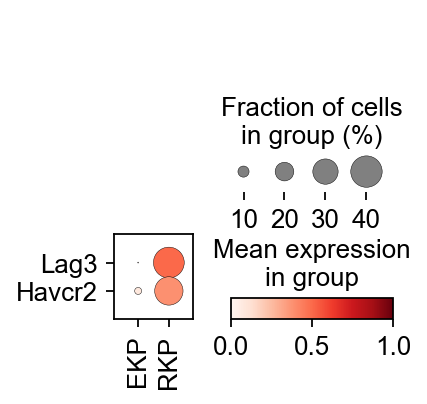

In [7]:
sc.pl.dotplot(adata_t, ['Lag3','Havcr2'], groupby='type', vmin=0, vmax=1, swap_axes=True, save='_Lag3_Havcr2.pdf')

In [16]:
adata_m = adata[adata.obs['celltype'].isin(['M1_Macrophage','M2_Macrophage', 'Macrophage'])]
adata_m

View of AnnData object with n_obs × n_vars = 4380 × 16462
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'tissue', 'type', 'leiden', 'batch', 'tissue_1', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt', 'n_counts', 'celltype'
    var: 'gene_ids_2', 'feature_types_2', 'mt_2', 'n_cells_2-0', 'n_cells_by_counts_2-0', 'mean_counts_2-0', 'pct_dropout_by_counts_2-0', 'total_counts_2-0', 'n_cells_2-1', 'n_cells_by_counts_2-1', 'mean_counts_2-1', 'pct_dropout_by_counts_2-1', 'total_counts_2-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'celltype_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'leiden_rank_fgsea', 'neighbors', 'pca', 'tissue_1_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [17]:
adata_m.write('Myeloid_cell.h5ad', compression = 'gzip')

In [18]:
adata_b = adata[adata.obs['celltype'].isin(['B cell'])]
adata_b

View of AnnData object with n_obs × n_vars = 61 × 16462
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'tissue', 'type', 'leiden', 'batch', 'tissue_1', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt', 'n_counts', 'celltype'
    var: 'gene_ids_2', 'feature_types_2', 'mt_2', 'n_cells_2-0', 'n_cells_by_counts_2-0', 'mean_counts_2-0', 'pct_dropout_by_counts_2-0', 'total_counts_2-0', 'n_cells_2-1', 'n_cells_by_counts_2-1', 'mean_counts_2-1', 'pct_dropout_by_counts_2-1', 'total_counts_2-1', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'celltype_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'leiden_rank_fgsea', 'neighbors', 'pca', 'tissue_1_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [19]:
adata_b.write('B_cell.h5ad', compression = 'gzip')